# The Daubechies D4 Wavelet Tranform

In [25]:
import numpy as np
import cv2
import IPython
from PIL import Image
import matplotlib.pyplot as plt
from time import time
from scipy.sparse import csr_matrix


def split_matrix(mat): # divide the matrix into 4 quadrants
    h, w = mat.shape
    return mat[:h // 2, :w // 2], mat[:h // 2, w // 2:], mat[h // 2:, :w // 2], mat[h // 2:, w // 2:]

def concatenate_matrices(m1, m2, m3, m4):
    return np.concatenate((np.concatenate((m1, m2), axis=1),
                            np.concatenate((m3, m4), axis=1)), axis=0)

def imshow(image, width=None):
    _, ret = cv2.imencode('.jpg', image)
    i = IPython.display.Image(data=ret, width=width)
    IPython.display.display(i)

def jpg_to_pgm(jpg_path):
    image = Image.open(jpg_path)
    image_gray = image.convert('L')
    width = image_gray.size[0]
    if (width>512):
        image_gray = image_gray.resize((512, 512))
        pixels = list(image_gray.getdata())

    else: pixels = list(image_gray.getdata())

    return np.array(pixels).reshape((512, 512))

def new_p(matrix):
    max,min  = np.max(matrix), np.min(matrix)
    for i in range(len(matrix)):
        for j in range(len(matrix[i])):
            matrix[i][j] = ((matrix[i][j]-min)*255.0)/(max-min)
    return matrix


def function_daubechies_coeffs(image):
    rows, cols = image.shape
    matrix_coeffs = np.zeros((rows, cols))

    for i in range(rows // 2):
        if i < rows // 2 - 1: 
            matrix_coeffs[i, 2 * i:2 * i + 4] = h_coeffs
        else:
            matrix_coeffs[i, 2 * i:2 * i + 2] = h_coeffs[:2]
            matrix_coeffs[i, 0:2] = h_coeffs[2:]

    for i in range(rows // 2):
        if i < rows // 2 - 1:
            matrix_coeffs[i + rows // 2, 2 * i:2 * i + 4] = g_coeffs
        else:
            matrix_coeffs[i + rows // 2, 2 * i:2 * i + 2] = g_coeffs[:2]
            matrix_coeffs[i + rows // 2, 0:2] = g_coeffs[2:]

    matriz = np.round(matrix_coeffs, 4)
    matriz_dispersa = csr_matrix(matriz)

    return matriz_dispersa
     
     
root2, root3 = np.sqrt(2), np.sqrt(3) 

h_coeffs = np.array([(1 + root3) / (4 * root2),
                     (3 + root3) / (4 * root2),
                     (3 - root3) / (4 * root2),
                     (1 - root3) / (4 * root2)])

g_coeffs = np.array([h_coeffs[3], 
                    -h_coeffs[2],
                     h_coeffs[1], 
                    -h_coeffs[0]])

In [26]:
def daubechies4_wavelet_transform_2D(daubechies_coeffs,image,scale,width, details = None):
    result_H = []

    for row in image: #ESTA PARTE HACE LA HORIZONTAL
        result_H.append(daubechies_coeffs.dot(row))
    result_V = daubechies_coeffs.dot(result_H)

    if (scale == 1) :
        normalized = np.copy(result_V)
        aP,cH,cV,cD = split_matrix(normalized)
        normalized = concatenate_matrices(new_p(aP),new_p(cH),new_p(cV),new_p(cD))
        if details is not None:
            for i in range(len(details)//3):
                result_V = concatenate_matrices(result_V,details[0+(i*3)],details[1+(i*3)],details[2+(i*3)])
                normalized = concatenate_matrices(new_p(normalized),new_p(details[0+(i*3)]),new_p(details[1+(i*3)]),new_p(details[2+(i*3)])) ########
  
            return result_V, normalized
        else:
            return result_V, normalized
        
    elif (np.log2(width//4) >= scale > 1):
        aP,cH,cV,cD = split_matrix(result_V)
        details = ([cH,cV,cD] + details) if details is not None else [cH,cV,cD]
        return daubechies4_wavelet_transform_2D(function_daubechies_coeffs(aP),aP,scale-1,aP.shape[0],details)

    else : print(f"Error. The scale value has to be between 1 - {int(np.log2(width//4))}"); return np.ones_like(image), np.ones_like(image)

In [27]:
def inverse_daubechies4_wavelet_transform_2D(daubechies_coeffs, transform_result,scale,width):
    new_transform = np.copy(transform_result)
    image = []
    
    if (scale == 1) :
        daubechies_coeffs_transpose = daubechies_coeffs.T
        
        result_H = daubechies_coeffs_transpose.dot(transform_result)
        for row in result_H:
            original_row = daubechies_coeffs_transpose.dot(row)
            image.append(original_row)
            
        return np.array(image)
    
    else: 
        tam_img = width // (2 ** scale) * 2
        daubechies_coeffs_transpose = (function_daubechies_coeffs(new_transform[:tam_img, :tam_img]))
        daubechies_coeffs_transpose = daubechies_coeffs_transpose.T
        
        result_H = daubechies_coeffs_transpose.dot(new_transform[:tam_img, :tam_img])
        for row in result_H:
            original_row = daubechies_coeffs_transpose.dot(row)
            image.append(original_row)

        new_transform[:len(image), :len(image)] = image

        return inverse_daubechies4_wavelet_transform_2D(function_daubechies_coeffs(new_transform),new_transform,scale-1,new_transform.shape[0])

In [28]:
def zeros(image, scale):
    tam_img = image.shape[0] // (2 ** scale)
    image[:tam_img, :tam_img] = np.zeros((tam_img, tam_img))
    return image

## NUMERIC EXAMPLE

In [29]:
example = np.random.randint(0.0, 52.0, (8, 8))
example_daubechies_4 = function_daubechies_coeffs(example)
example_daubechies_4_transposed = np.transpose(example_daubechies_4)
print(f"\nCoeffs Matrix:\n {example_daubechies_4}")
print(f"\nCoeffs Matrix Transposed:\n {example_daubechies_4_transposed}")


Coeffs Matrix:
   (0, 0)	0.483
  (0, 1)	0.8365
  (0, 2)	0.2241
  (0, 3)	-0.1294
  (1, 2)	0.483
  (1, 3)	0.8365
  (1, 4)	0.2241
  (1, 5)	-0.1294
  (2, 4)	0.483
  (2, 5)	0.8365
  (2, 6)	0.2241
  (2, 7)	-0.1294
  (3, 0)	0.2241
  (3, 1)	-0.1294
  (3, 6)	0.483
  (3, 7)	0.8365
  (4, 0)	-0.1294
  (4, 1)	-0.2241
  (4, 2)	0.8365
  (4, 3)	-0.483
  (5, 2)	-0.1294
  (5, 3)	-0.2241
  (5, 4)	0.8365
  (5, 5)	-0.483
  (6, 4)	-0.1294
  (6, 5)	-0.2241
  (6, 6)	0.8365
  (6, 7)	-0.483
  (7, 0)	0.8365
  (7, 1)	-0.483
  (7, 6)	-0.1294
  (7, 7)	-0.2241

Coeffs Matrix Transposed:
   (0, 0)	0.483
  (1, 0)	0.8365
  (2, 0)	0.2241
  (3, 0)	-0.1294
  (2, 1)	0.483
  (3, 1)	0.8365
  (4, 1)	0.2241
  (5, 1)	-0.1294
  (4, 2)	0.483
  (5, 2)	0.8365
  (6, 2)	0.2241
  (7, 2)	-0.1294
  (0, 3)	0.2241
  (1, 3)	-0.1294
  (6, 3)	0.483
  (7, 3)	0.8365
  (0, 4)	-0.1294
  (1, 4)	-0.2241
  (2, 4)	0.8365
  (3, 4)	-0.483
  (2, 5)	-0.1294
  (3, 5)	-0.2241
  (4, 5)	0.8365
  (5, 5)	-0.483
  (4, 6)	-0.1294
  (5, 6)	-0.2241
  (6, 6)	0.83

In [30]:
aP,cH,cV,cD = split_matrix(example)
scale = 1
dwt, normal = daubechies4_wavelet_transform_2D(example_daubechies_4,example,scale,example.shape[0])
idwt = inverse_daubechies4_wavelet_transform_2D(example_daubechies_4,dwt,scale,dwt.shape[0])

print(f"Original Matrix:\n {example}")
print(f"\nDirect daubechies Wavelet Transform\n {np.round(dwt,0)}")
print(f"\nInverse daubechies Wavelet Transform\n {np.round((idwt),0)}")

Original Matrix:
 [[ 2 17 47 39 18 21 34 11]
 [ 2  5  7 48  9  9  0 16]
 [42 50  7  5  6 42 36 41]
 [ 1 21 51 23  4 49 10 32]
 [ 3  4 21 50 22 14 39 49]
 [43 14 20  1  9 22 15  2]
 [12  5 26 13 39 49 50 16]
 [49  2  0 27 41 27 34  2]]

Direct daubechies Wavelet Transform
 [[ 21.  60.  28.  31. -14. -12.   1.  -8.]
 [ 49.  45.  56.  62.  13. -35. -16. -23.]
 [ 33.  37.  43.  48.   8.  -7.   8.  10.]
 [ 30.  43.  81.  47.  -4.  13.  27.  26.]
 [ 37. -33.   8.  26. -22.   4.   9.   9.]
 [-29.  32.  -6.  28. -15.  10.   4. -22.]
 [ -7.  -1.  25.   8.  20.  -3.   6. -23.]
 [ 10.  16.   2.   2.  26.  -8.  13. -17.]]

Inverse daubechies Wavelet Transform
 [[ 2. 17. 47. 39. 18. 21. 34. 11.]
 [ 2.  5.  7. 48.  9.  9. -0. 16.]
 [42. 50.  7.  5.  6. 42. 36. 41.]
 [ 1. 21. 51. 23.  4. 49. 10. 32.]
 [ 3.  4. 21. 50. 22. 14. 39. 49.]
 [43. 14. 20.  1.  9. 22. 15.  2.]
 [12.  5. 26. 13. 39. 49. 50. 16.]
 [49.  2. -0. 27. 41. 27. 34.  2.]]


## IMAGES EXAMPLES

In [31]:
photo = 'imagen.jpg'

0.875502347946167


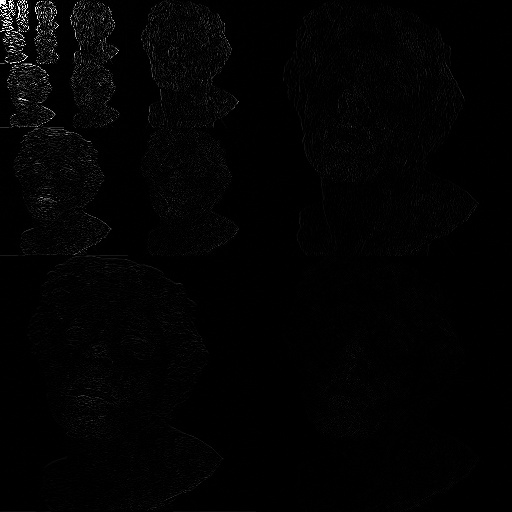

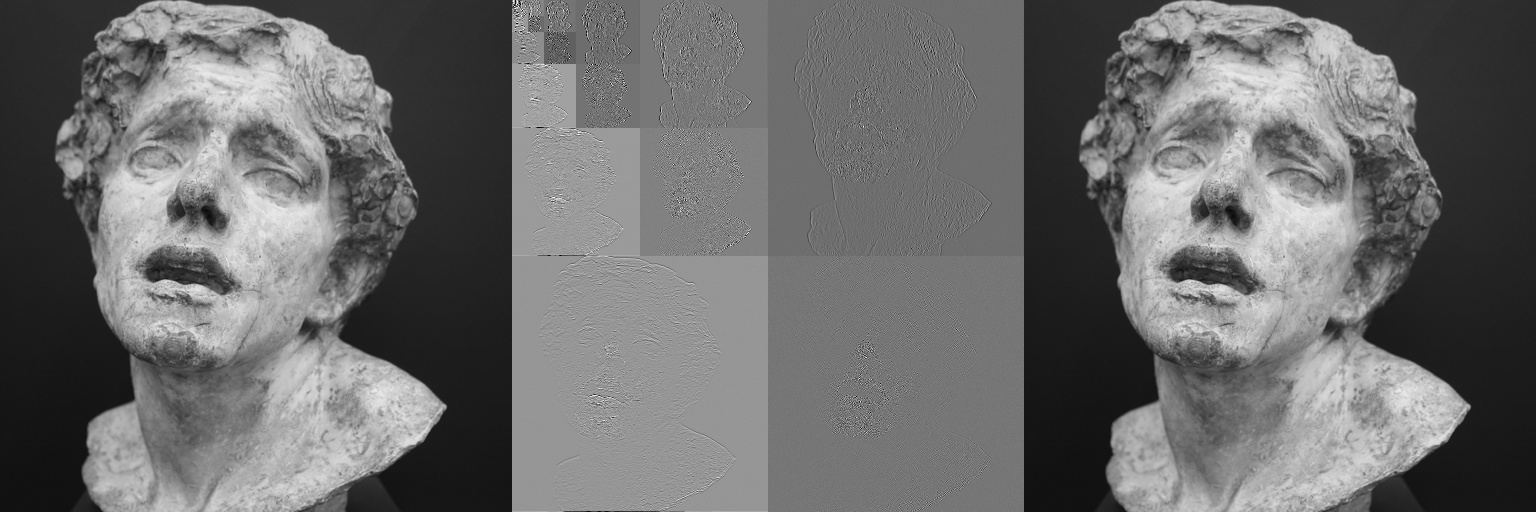

In [32]:
initial_time = time() 
array_photo = jpg_to_pgm(photo)
daubechies_4 = function_daubechies_coeffs(array_photo)
scale, width = 7, array_photo.shape[0]
result_img, normalized= daubechies4_wavelet_transform_2D(daubechies_4,array_photo,scale,width)
# result_img = zeros(result_img, scale)
reconstructed = inverse_daubechies4_wavelet_transform_2D(daubechies_4,result_img,scale,width)
final_time = time()


execution_time = final_time - initial_time
print(execution_time)
imshow(result_img)
imshow(np.concatenate((array_photo, normalized, reconstructed), axis = 1))
